In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

tf.random.set_seed(123)
np.random.seed(123)

In [3]:
# ------------------------------
# 1. For SARIMAX modeling (using manual grid search)
# ------------------------------
def grid_search_sarimax(y, exog, p_range=range(0, 3), d_range=range(0, 2), q_range=range(0, 3),
                        P_range=range(0, 2), D_range=range(0, 2), Q_range=range(0, 2), m=7):
    best_aic = np.inf
    best_order = None
    best_seasonal_order = None
    for p in p_range:
        for d in d_range:
            for q in q_range:
                for P in P_range:
                    for D in D_range:
                        for Q in Q_range:
                            order = (p, d, q)
                            seasonal_order = (P, D, Q, m)
                            try:
                                model = SARIMAX(y, exog=exog, order=order,
                                                seasonal_order=seasonal_order,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                                res = model.fit(disp=False)
                                if res.aic < best_aic:
                                    best_aic = res.aic
                                    best_order = order
                                    best_seasonal_order = seasonal_order
                            except Exception:
                                continue
    return best_order, best_seasonal_order

In [4]:
# ------------------------------
# 2. Evaluation metrics
# ------------------------------
def evaluate_forecasts(test_actual, test_forecast, train_actual):
    mae = mean_absolute_error(test_actual, test_forecast)
    mape = mean_absolute_percentage_error(test_actual, test_forecast) * 100
    # MASE: scale error by the one-step naive forecast error on training data
    naive_error = np.mean(np.abs(np.diff(train_actual)))
    mase = mae / (naive_error + 1e-8)
    # sMAPE: symmetric MAPE
    smape = 100 * np.mean(2 * np.abs(test_actual - test_forecast) / (np.abs(test_actual) + np.abs(test_forecast) + 1e-8))
    return mae, mape, mase, smape

In [5]:
# ------------------------------
# 3. Deep Learning: LSTM for residual modeling
# ------------------------------
def forecast_residual_lstm_pd(residual_series, forecast_horizon, window_size=30, n_epochs=100, batch_size=16, n_units=50):
    scaler = MinMaxScaler(feature_range=(0, 1))
    res_values = residual_series.values.reshape(-1, 1)
    res_scaled = scaler.fit_transform(res_values)
    
    # Create sequences (using a simple sliding window)
    X, y = [], []
    for i in range(len(res_scaled) - window_size):
        X.append(res_scaled[i:i+window_size])
        y.append(res_scaled[i+window_size])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    model = Sequential()
    model.add(LSTM(n_units, activation='relu', input_shape=(window_size, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mae')
    model.fit(X, y, epochs=n_epochs, batch_size=batch_size, verbose=0)
    
    # Use the last window to forecast out the residuals
    last_seq = res_scaled[-window_size:]
    forecast_residual_scaled = []
    current_seq = last_seq.copy()
    for _ in range(forecast_horizon):
        pred = model.predict(current_seq.reshape(1, window_size, 1))
        forecast_residual_scaled.append(pred[0, 0])
        new_val = pred.reshape(1, 1)
        current_seq = np.append(current_seq[1:], new_val, axis=0)
    forecast_res = scaler.inverse_transform(np.array(forecast_residual_scaled).reshape(-1, 1)).flatten()
    forecast_dates = pd.date_range(residual_series.index[-1] + pd.Timedelta(days=1),
                                   periods=forecast_horizon, freq='D')
    return pd.Series(forecast_res, index=forecast_dates)

In [6]:
# ------------------------------
# 4. Utility: Log-transformation functions
# ------------------------------
def log_transform(series, offset=1.0):
    return np.log(series + offset)

def inverse_log_transform(log_series, offset=1.0):
    return np.exp(log_series) - offset

In [7]:
# ------------------------------
# 5. Feature Engineering for both branches
# ------------------------------
def add_features(df, target_col='cpu_used'):
    df_feat = df.copy().sort_index()
    df_feat['lag1'] = df_feat[target_col].shift(1)
    df_feat['lag2'] = df_feat[target_col].shift(2)
    df_feat['lag3'] = df_feat[target_col].shift(3)
    df_feat['rolling_mean_7'] = df_feat[target_col].rolling(window=7).mean().shift(1)
    df_feat['rolling_median_7'] = df_feat[target_col].rolling(window=7).median().shift(1)
    df_feat['dow'] = df_feat.index.dayofweek
    df_feat['day_sin'] = np.sin(2 * np.pi * df_feat['dow'] / 7)
    df_feat['day_cos'] = np.cos(2 * np.pi * df_feat['dow'] / 7)
    return df_feat.dropna()

In [8]:
def prepare_model_data(df, target_col='cpu_used', offset=1.0):
    df_feat = add_features(df, target_col=target_col)
    df_feat['y_log'] = log_transform(df_feat[target_col], offset=offset)
    for col in ['lag1', 'lag2', 'lag3', 'rolling_mean_7', 'rolling_median_7', 'day_sin', 'day_cos']:
        df_feat[col] = pd.to_numeric(df_feat[col])
    return df_feat

In [9]:
# ------------------------------
# 6. SARIMAX Branch with Hybrid Residual Modeling (Log-scale)
# ------------------------------
def sarimax_branch_forecast(train_df, test_df, exog_cols, forecast_horizon, offset=1.0, m=7):
    y_train = train_df['y_log']
    exog_train = train_df[exog_cols]
    exog_test = test_df[exog_cols]
    
    best_order, best_seasonal_order = grid_search_sarimax(y_train, exog_train, m=m)
    print("SARIMAX grid search selected order:", best_order, "seasonal_order:", best_seasonal_order)
    
    model = SARIMAX(y_train, exog=exog_train, order=best_order, seasonal_order=best_seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    sarimax_fit = model.fit(disp=False)
    forecast_base = sarimax_fit.get_forecast(steps=forecast_horizon, exog=exog_test).predicted_mean
    forecast_base.index = test_df.index
    
    in_sample_pred = sarimax_fit.predict(start=y_train.index[0], end=y_train.index[-1], exog=exog_train)
    residual_train = y_train - in_sample_pred
    forecast_res = forecast_residual_lstm_pd(residual_train, forecast_horizon, window_size=30,
                                              n_epochs=100, batch_size=16, n_units=50)
    final_forecast_log = forecast_base + forecast_res
    final_forecast = inverse_log_transform(final_forecast_log, offset=offset)
    return final_forecast, sarimax_fit, best_order, best_seasonal_order, residual_train

In [30]:
# ------------------------------
# 7. Prophet Branch with Hybrid Residual Modeling (Log-scale)
# ------------------------------
def prophet_branch_forecast(train_df, test_df, exog_cols, forecast_horizon, offset=1.0):
    # For Prophet, reset index and ensure a 'ds' column.
    prophet_train = train_df.copy().reset_index()
    if 'ds' not in prophet_train.columns:
        prophet_train = prophet_train.rename(columns={'date': 'ds'})
    # Train Prophet on log target with extra regressors.
    m_prophet = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True,
                         changepoint_prior_scale=0.1, seasonality_prior_scale=10)
    for reg in exog_cols:
        m_prophet.add_regressor(reg)
    m_prophet.fit(prophet_train[['ds', 'y_log'] + exog_cols].rename(columns={'y_log': 'y'}))
    
    # Future dataframe for Prophet: use the last observed values for extra regressor columns.
    last_date = prophet_train['ds'].iloc[-1]
    last_vals = prophet_train[exog_cols].iloc[-1]
    future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=forecast_horizon, freq='D')
    future_df = pd.DataFrame({'ds': future_dates})
    for reg in exog_cols:
        future_df[reg] = float(last_vals[reg])
    
    forecast_prophet_df = m_prophet.predict(future_df)
    forecast_base = forecast_prophet_df['yhat']
    forecast_base.index = future_df['ds']
    
    forecast_train = m_prophet.predict(prophet_train)
    residual_train = prophet_train['y_log'] - forecast_train['yhat']
    residual_train = pd.Series(residual_train.values, index=prophet_train['ds'])
    forecast_res = forecast_residual_lstm_pd(residual_train, forecast_horizon, window_size=30,
                                              n_epochs=100, batch_size=16, n_units=50)
    final_forecast_log = forecast_base + forecast_res
    final_forecast = inverse_log_transform(final_forecast_log, offset=offset)
    return final_forecast, m_prophet, residual_train

In [11]:
# ------------------------------
# 8. Optimize Ensemble Weight (using Validation)
# ------------------------------
def optimize_ensemble_weight(forecast1, forecast2, actual):
    weights = np.linspace(0, 1, 101)
    best_w = None
    best_mape = np.inf
    for w in weights:
        combined = w * forecast1 + (1 - w) * forecast2
        mape_val = mean_absolute_percentage_error(actual, combined) * 100
        if mape_val < best_mape:
            best_mape = mape_val
            best_w = w
    return best_w, best_mape

In [12]:
# ------------------------------
# 9. Full Hybrid Pipeline (Training/Validation/Test split)
# ------------------------------
def run_hybrid_pipeline(df_ns, forecast_horizon=30, val_horizon=15, offset=1.0):
    df_all = prepare_model_data(df_ns, target_col='cpu_used', offset=offset)
    df_all = df_all.sort_index()
    total = len(df_all)
    # Partition: last forecast_horizon for test, preceding val_horizon for validation.
    train_df = df_all.iloc[: total - (forecast_horizon + val_horizon)]
    val_df   = df_all.iloc[total - (forecast_horizon + val_horizon) : total - forecast_horizon]
    test_df  = df_all.iloc[total - forecast_horizon:]
    
    exog_cols = ['lag1','lag2','lag3','rolling_mean_7','rolling_median_7','day_sin','day_cos']
    
    # --- Validation Forecasts ---
    forecast_sarimax_val, _, _, _, _ = sarimax_branch_forecast(train_df, val_df, exog_cols, forecast_horizon=val_horizon, offset=offset)
    forecast_prophet_val, _, _ = prophet_branch_forecast(train_df, val_df, exog_cols, forecast_horizon=val_horizon, offset=offset)
    actual_val = val_df['cpu_used']
    w_opt, opt_mape = optimize_ensemble_weight(forecast_sarimax_val, forecast_prophet_val, actual_val)
    print(f"\nOptimized ensemble weight on Validation (SARIMAX weight): {w_opt:.2f} with Validation MAPE: {opt_mape:.2f}%")
    
    # --- Test Forecasts ---
    combined_train_val = pd.concat([train_df, val_df])
    forecast_sarimax_test, _, _, _, _ = sarimax_branch_forecast(combined_train_val, test_df, exog_cols, forecast_horizon=forecast_horizon, offset=offset)
    forecast_prophet_test, _, _ = prophet_branch_forecast(combined_train_val, test_df, exog_cols, forecast_horizon=forecast_horizon, offset=offset)
    ensemble_test = w_opt * forecast_sarimax_test + (1 - w_opt) * forecast_prophet_test
    actual_test = test_df['cpu_used']
    
    mae, mape, mase, smape = evaluate_forecasts(actual_test, ensemble_test, train_df['cpu_used'])
    
    return {
         "train_df": train_df,
         "val_df": val_df,
         "test_df": test_df,
         "forecast_sarimax_val": forecast_sarimax_val,
         "forecast_prophet_val": forecast_prophet_val,
         "w_opt": w_opt,
         "ensemble_val": w_opt * forecast_sarimax_val + (1 - w_opt) * forecast_prophet_val,
         "forecast_sarimax_test": forecast_sarimax_test,
         "forecast_prophet_test": forecast_prophet_test,
         "ensemble_test": ensemble_test,
         "actual_test": actual_test,
         "mae": mae,
         "mape": mape,
         "mase": mase,
         "smape": smape
    }

In [13]:
# ------------------------------
# 10. Future Forecast Function (Forecast the next 30 days beyond the available data)
# ------------------------------
def run_future_forecast(df_ns, forecast_horizon=30, offset=1.0):
    """
    Use the entire available data as training and forecast the next forecast_horizon days.
    For SARIMAX, a test DataFrame is built with future dates and exogenous regressors set to the last observed.
    For Prophet, a future DF is built internally.
    We then ensemble the two forecasts with equal weighting.
    """
    df_all = prepare_model_data(df_ns, target_col='cpu_used', offset=offset)
    df_all = df_all.sort_index()
    exog_cols = ['lag1','lag2','lag3','rolling_mean_7','rolling_median_7','day_sin','day_cos']
    train_df = df_all.copy()
    # Create a test dataframe with future dates for SARIMAX
    last_date = train_df.index[-1]
    future_index = pd.date_range(last_date + pd.Timedelta(days=1), periods=forecast_horizon, freq='D')
    test_df = pd.DataFrame(index=future_index)
    for col in exog_cols:
        test_df[col] = train_df[col].iloc[-1]
    
    forecast_sarimax, _, _, _, _ = sarimax_branch_forecast(train_df, test_df, exog_cols, forecast_horizon, offset=offset)
    # For Prophet, create an artificial dummy test_df; the function uses the train_df to build future dates.
    dummy_test = pd.DataFrame(index=future_index)
    for col in exog_cols:
        dummy_test[col] = train_df[col].iloc[-1]
    forecast_prophet, _, _ = prophet_branch_forecast(train_df, dummy_test, exog_cols, forecast_horizon, offset=offset)
    
    ensemble_forecast = 0.5 * forecast_sarimax + 0.5 * forecast_prophet
    return ensemble_forecast, forecast_sarimax, forecast_prophet

Processing namespace: alpha
SARIMAX grid search selected order: (0, 1, 1) seasonal_order: (0, 0, 1, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


11:44:36 - cmdstanpy - INFO - Chain [1] start processing
11:44:36 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step

Optimized ensemble weight on Validation (SARIMAX weight): 1.00 with Validation MAPE: 24.53%
SARIMAX grid search selected order: (0, 1, 1) seasonal_order: (0, 0, 1, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8

11:59:56 - cmdstanpy - INFO - Chain [1] start processing
11:59:56 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━

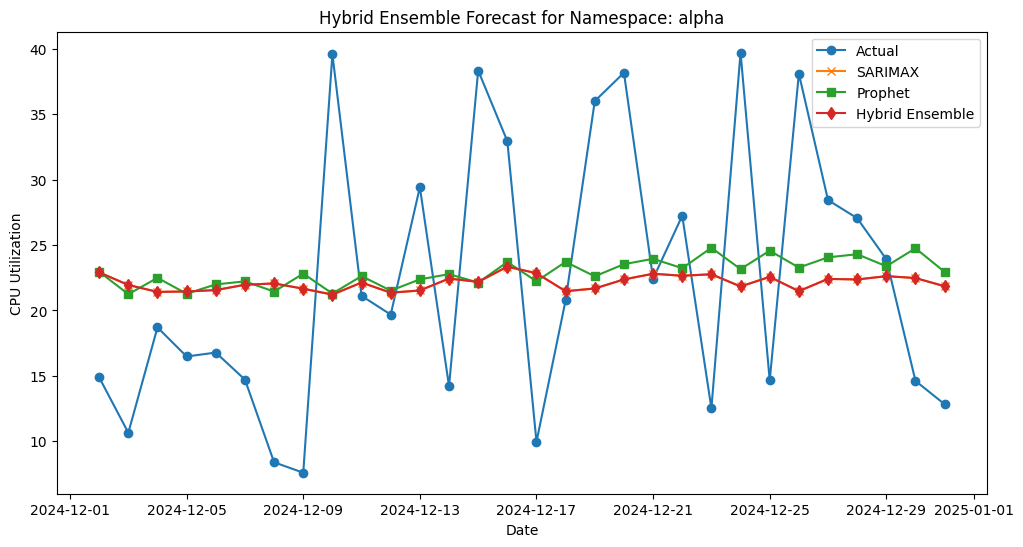

Processing namespace: beta
SARIMAX grid search selected order: (0, 1, 1) seasonal_order: (0, 0, 1, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


12:14:12 - cmdstanpy - INFO - Chain [1] start processing
12:14:13 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step

Optimized ensemble weight on Validation (SARIMAX weight): 0.00 with Validation MAPE: 37.22%


KeyboardInterrupt: 

In [45]:
# ------------------------------
# 11. MAIN EXECUTION: Process each namespace and then forecast Future 30 Days
# ------------------------------
if __name__ == '__main__':
    # Read CSV: It should have columns: date, namespace, cpu_used.
    df = pd.read_csv("../data/cpu_usage_test.csv", parse_dates=["date"])
    df.set_index("date", inplace=True)
    
    results = {}
    
    for ns in df["namespace"].unique():
        print("==========================================")
        print(f"Processing namespace: {ns}")
        df_ns = df[df["namespace"] == ns]
        try:
            res = run_hybrid_pipeline(df_ns, forecast_horizon=30, val_horizon=15, offset=1.0)
        except Exception as e:
            print(f"Error processing namespace {ns}: {e}")
            continue
        
        print(f"Namespace: {ns} -> Test MAE: {res['mae']:.4f}, Test MAPE: {res['mape']:.2f}%, Test MASE: {res['mase']:.2f}, Test sMAPE: {res['smape']:.2f}%")
        results[ns] = res
        
        plt.figure(figsize=(12,6))
        plt.plot(res['test_df'].index, res['actual_test'], label="Actual", marker="o")
        plt.plot(res['forecast_sarimax_test'].index, res['forecast_sarimax_test'], label="SARIMAX", marker="x")
        plt.plot(res['forecast_prophet_test'].index, res['forecast_prophet_test'], label="Prophet", marker="s")
        plt.plot(res['ensemble_test'].index, res['ensemble_test'], label="Hybrid Ensemble", marker="d")
        plt.title(f"Hybrid Ensemble Forecast for Namespace: {ns}")
        plt.xlabel("Date")
        plt.ylabel("CPU Utilization")
        plt.legend()
        plt.show()
    
    # Summary of test performance
    print("\nSummary of Test Forecast Performance:")
    for ns, res in results.items():
        print(f"Namespace: {ns} -> MAE: {res['mae']:.4f}, MAPE: {res['mape']:.2f}%, MASE: {res['mase']:.2f}, sMAPE: {res['smape']:.2f}%")
    
    # Now produce future forecast (next 30 days beyond available data) for each namespace:
    print("\nFuture 30-day Forecasts:")
    future_results = {}
    for ns in df["namespace"].unique():
        df_ns = df[df["namespace"] == ns]
        try:
            future_forecast, fc_sarimax, fc_prophet = run_future_forecast(df_ns, forecast_horizon=30, offset=1.0)
            future_results[ns] = future_forecast
            plt.figure(figsize=(12,6))
            plt.plot(future_forecast.index, future_forecast, label="Hybrid Future Forecast", marker="d")
            plt.title(f"Future 30-day Forecast for Namespace: {ns}")
            plt.xlabel("Date")
            plt.ylabel("CPU Utilization")
            plt.legend()
            plt.show()
            print(f"Namespace: {ns} Future Forecast:\n{future_forecast}\n")
        except Exception as e:
            print(f"Error forecasting future for namespace {ns}: {e}")